# Matrix Factorization++
solution inspired by the Netflix challenge winners

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../')

from pathlib import Path

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn import MSELoss

from src.models.torch.mf import MatrixFactorization
from src.models.torch.trainer import train_mf
from src.models.torch.util import get_dataloaders
from src.util.data import get_train_test_ratings
# from src.util.metrics import get_jaccard_ranking, get_classification_ranking_metrics, get_r2_score, get_ndcg_score
from src.util.plot import Plot

plot = Plot()

RATINGS_PATH = Path('../data/ratings_small.csv')
OUTPUT_PATH = Path('../models/matrix_factorization2.pt')

# Data

In [2]:
ratings = pd.read_csv(RATINGS_PATH)

In [3]:
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'].values)

movie_encoder = LabelEncoder()
movie_encoder.fit(ratings['movieId'].values);

In [4]:
train_ratings, test_ratings = get_train_test_ratings(ratings)

In [5]:
train_ratings_reindexed = train_ratings.copy()
train_ratings_reindexed['userId'] = \
    user_encoder.transform(train_ratings_reindexed['userId'].values)
train_ratings_reindexed['movieId'] = \
    movie_encoder.transform(train_ratings_reindexed['movieId'].values)

train_loader, test_loader = \
    get_dataloaders(train_ratings, test_ratings, 
                    user_encoder, movie_encoder)

# Model

In [6]:
results = []
hiperparams_list = [
    {'seed':0, 'h_dim': 5, 'lr':1e-2, 'L2_reg':[1.6, 1.6], 'MLP':False},
    {'seed':0, 'h_dim': 20, 'lr':1e-2, 'L2_reg':[3.0, 3.0], 'MLP':False},
    {'seed':0, 'h_dim': 160, 'lr':1e-2, 'L2_reg':[7.3, 7.3], 'MLP':False},
    {'seed':0, 'h_dim': 160, 'lr':1e-2, 'L2_reg':[7.3, 7.3], 'MLP':True},
]

In [7]:
for hparams in hiperparams_list:
    torch.manual_seed(hparams['seed'])
    model = MatrixFactorization(
        users_dim=len(user_encoder.classes_),
        movies_dim=len(movie_encoder.classes_),
        h_dim=hparams['h_dim'],
        use_mlp=hparams['MLP']
        )
    model.initialize(train_ratings_reindexed, embedding_rescaler=0.01)

    metrics = train_mf(
        model, train_loader, test_loader,
        epochs=30, lr=hparams['lr'],
        regularizing_params=hparams['L2_reg'],
        comment=f'MLP={hparams["MLP"]}'\
            f'_seed{hparams["seed"]}'
            f'_lr={hparams["lr"]}'
            f'_regL2={hparams["L2_reg"]}'
            f'_h_dim={hparams["h_dim"]}')
    results.append({
        **metrics,
        'seed': hparams['seed'],
        'lr': hparams['lr'],
        'user_embed_regularizer': hparams['L2_reg'][0],
        'movie_embed_regularizer': hparams['L2_reg'][1],
        'embedding_dim': hparams['h_dim'],
        'extra_MLP_bias': hparams['MLP'],
    })

epochs:   0%|          | 0/31 [00:00<?, ?it/s]

batches:   0%|          | 0/10 [00:00<?, ?it/s]

epochs:   0%|          | 0/31 [00:00<?, ?it/s]

batches:   0%|          | 0/10 [00:00<?, ?it/s]

epochs:   0%|          | 0/31 [00:00<?, ?it/s]

batches:   0%|          | 0/10 [00:00<?, ?it/s]

epochs:   0%|          | 0/31 [00:00<?, ?it/s]

batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
pd.DataFrame(results)

,RMSE,Loss,seed,lr,user_embed_regularizer,movie_embed_regularizer,embedding_dim,extra_MLP_bias
0,0.893369,0.798108,0,0.01,1.6,1.6,5,False
1,0.884281,0.781953,0,0.01,3.0,3.0,20,False
2,0.878033,0.770942,0,0.01,7.3,7.3,160,False
3,0.863952,0.746413,0,0.01,7.3,7.3,160,True


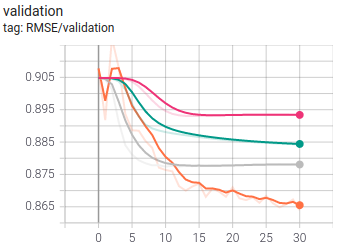

In [12]:
#save the last model (with MLP)
model.set_label_encoders(user_encoder, movie_encoder)
torch.save(model, OUTPUT_PATH)

# Tests

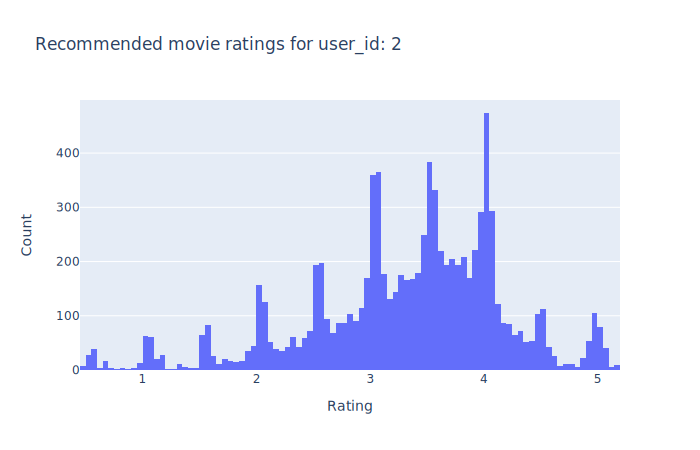

In [10]:
with torch.no_grad():
    _, scores = model.predict_scores(2)
    plot.histogram(
        x=scores,
        title=f'Recommended movie ratings for user_id: {2}',
        xaxis_title='Rating',
        yaxis_title='Count'
    )

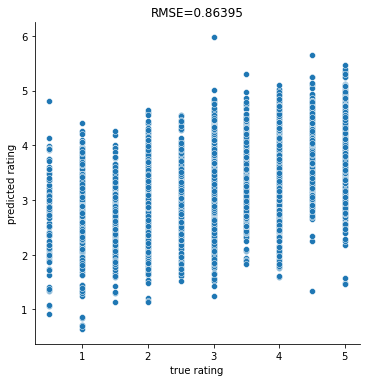

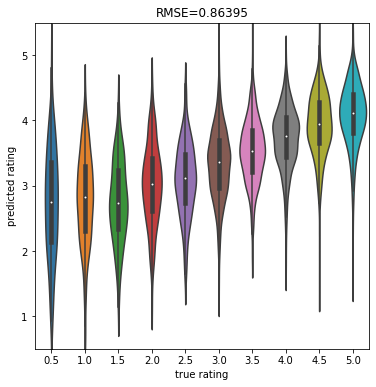

In [11]:
#cell to be deleted:
import seaborn as sns
import matplotlib.pyplot as plt

trues = []
preds = []
for (users, movies, ratings) in test_loader:
    with torch.no_grad():
        est_rating = model(users, movies)
    trues.append(ratings.cpu())
    preds.append(est_rating.cpu())
trues = torch.cat(trues)
preds = torch.cat(preds)
plot_settings = {
    'title': f"RMSE={(trues-preds).pow(2).mean().pow(.5):.5}",
    'xlabel': 'true rating',
    'ylabel': 'predicted rating',
}
sns.relplot(x=trues, y=preds).set(**plot_settings);
plt.figure(figsize=(6,6))
sns.violinplot(x=trues.numpy(), y=preds.numpy()).set(ylim=(.5,5.5), **plot_settings);